In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import mean_squared_error, f1_score, classification_report, confusion_matrix, make_scorer
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.svm import SVC
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import GridSearchCV

In [2]:
import pandas as pd

# Load the uploaded Excel file to inspect its contents.
file_path = 'diabetes_ds.xlsx'
diabetes_data = pd.ExcelFile(file_path)

# Display the sheet names to understand the structure of the file.
diabetes_data.sheet_names

data_sheet = diabetes_data.parse('данные')
legend_sheet = diabetes_data.parse('Легенда')

# Display the first few rows of each sheet to understand their structure.
data_preview = data_sheet.head()
legend_preview = legend_sheet.head()

pd.set_option('display.max_columns', None)
display(data_sheet)

,Номер,Перенес/ не перенес КВИ,Возраст,Пол,"Рост, см","Вес, кг",ИМТ 2 (ФОРМУЛА EXCEL),Эритроциты,Гемоглобин,Цветовой показатель,Лейкоциты,Лимфоциты%,"ЛИМФОЦИТЫ, АБС (РАСЧЕТ ПО ФОРМУЛЕ)",Тромбоциты,СОЭ,Холестерин,ЛПНП,ЛПВП,Индекс атерогенности 2 (формула excel),Глюкоза,Гликированный гемоглобин,СРБ,Ферритин,Прокальцитонин,Альбумин,Лактат,ЛДГ,АЛТ,АСТ,Общий билирубин,Натрийуретический пептид,Мочевина,"Креатинин, мкмоль/л",СКФ CKD-EPI (расчет по общей формуле),Натрий,Калий,АЧТВ,МНО,Фибриноген,D-димер,Фавипиравир,Молнупиравир,Гидрохлортиазид,Фуросемид,Торасемид,Спиронолактон,Валсартан,Телмисартан,Лозартан,Кандесартан,Изосорбида динитрат,Периндоприл,Рамиприл,Эналаприл,Лизиноприл,Бисопролол,Карведилол,Атенолол,Верапамил,Дилтиазем,Леркамен,Амлодипин,Дигоксин,Ивабрадин,Гиполипидемические препараты (статины),"Антикоагулянты, препарат","Антикоагулянты, препарат 2","Антиагреганты, препарат 1","Антиагреганты, препарат 2",Триметазидин,Метформин,Дапаглифлозин,СТЕПЕНИ ОЖИРЕНИЯ ПО ИМТ,ОЖИРЕНИЕ (ЕСТЬ\НЕТ),BPB голеней,BPB голеней (ЕСТЬ/НЕТ),Тромбоэмболический синдром,ВПС,НЕАЖБП,Гипертрофия миокарда левого желудочка по ЭКГ или ЭХО-КГ,Гипертрофия миокарда левого желудочка по ЭКГ или ЭХО-КГ (комментарий),Блокада НП Гисса,Блокада НП Гисса (комментарий),Удлинение интервала QT,AV- блокада,ХБП (исходн),ХБП (расчет по СКФ),ХБП (ЕСТЬ\НЕТ),Мерцательная аритмия,Мерцательная аритмия (ЕСТЬ\НЕТ),Аблация,АКШ,БА,БА (ЕСТЬ/НЕТ),ХОБЛ,ХОБЛ (ЕСТЬ\НЕТ),ИБС. Стенокардия,ИБС. Стенокардия (ЕСТЬ\НЕТ),ИБС. ПИКС,ИБС. ПИКС (ЕСТЬ\НЕТ),"АГ, стадия",АГ (ЕСТЬ\НЕТ),"АГ, степень","АГ, риск","ХСН, стадии","ХСН, ФК","ХСН по фракции выброса, %",Сахарный диабет (ЕСТЬ\НЕТ)
0,390.0,1.0,68.0,2.0,158.0,86.0,34.449607,5.33,163.0,0.0,9.61,31.9,3.06559,201.0,8.0,4.14,2.25,0.97,3.268041,5.77,6.5,0.19,NaN,NaN,NaN,NaN,NaN,24.0,21.0,NaN,197.7,NaN,79.80,65.460393,NaN,5.76,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,NaN,1.0,NaN,0.0,1.0,1.0,1.0,1.0,0,0.0,0.0,0.0,1.0,0.0,NaN,0,NaN,0.0,0,0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,1.0,1.0,3.0,1.0,3.0,4.0,2.0,2.0,0,1.0
1,337.0,1.0,54.0,1.0,180.0,119.0,36.728395,5.01,130.0,0.0,10.48,19.0,1.99120,288.0,5.0,3.43,1.31,1.19,1.882353,5.91,6.1,NaN,NaN,NaN,46.0,NaN,NaN,12.0,14.0,NaN,2358.0,10.10,107.28,67.223532,140.4,4.38,38.2,2.34,3.71,NaN,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,NaN,1.0,NaN,0.0,1.0,1.0,2.0,1.0,1,1.0,1.0,0.0,0.0,1.0,умеренная гипертрофия,1,полная блокада,0.0,0,с3б,2.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,3.0,1.0,1.0,1.0,3.0,1.0,3.0,4.0,2.0,3.0,35,1.0
2,160.0,1.0,68.0,1.0,174.0,110.0,36.332409,NaN,161.0,0.0,5.40,25.6,1.38240,114.0,10.0,4.23,2.69,0.94,3.500000,6.61,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16.5,20.7,18.1,NaN,NaN,106.20,61.677030,140.6,4.30,33.7,NaN,NaN,NaN,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,NaN,1.0,NaN,0.0,0.0,0.0,2.0,1.0,1,1.0,0.0,0.0,0.0,1.0,NaN,1-2,NaN,0.0,1,с3,2.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,1.0,1.0,1.0,3.0,1.0,3.0,4.0,3.0,3.0,35,1.0
3,166.0,1.0,67.0,1.0,189.0,110.0,30.794211,4.47,134.0,0.0,8.50,13.3,1.13050,175.0,5.0,NaN,NaN,NaN,NaN,4.98,NaN,20.35,NaN,NaN,43.6,NaN,327.0,17.9,23.8,23.3,454.6,10.78,91.20,74.666361,140.6,4.00,26.3,1.09,3.68,NaN,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,NaN,1.0,NaN,0.0,1.0,0.0,1.0,1.0,0,0.0,0.0,0.0,0.0,0.0,NaN,1,NaN,0.0,1,0,2.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,2.0,1.0,1.0,1.0,3.0,1.0,3.0,4.0,3.0,3.0,0,1.0
4,439.0,1.0,60.0,1.0,178.0,115.0,36.295922,5.44,166.0,0.0,9.06,28.3,2.56398,226.0,5.0,3.25,1.45,1.30,1.500000,9.48,7.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,280.7,3.20,81.70,89.585462,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,0.0,NaN,1.0,NaN,0.0,0.0,1.0,2.0,1.0,0,0.0,0.0,0.0,0.0,0.0,NaN,0,NaN,0.0,0,0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,2

In [3]:
data_sheet = data_sheet.dropna(subset=['Номер', 'Сахарный диабет (ЕСТЬ\НЕТ)']) 

In [4]:
data_sheet.drop(columns= ['Блокада НП Гисса (комментарий)', 'Гипертрофия миокарда левого желудочка по ЭКГ или ЭХО-КГ (комментарий)', 'ХБП (исходн)'], inplace=True)

In [5]:
# Функция для обработки значений диапазона
def process_fraction(value):
    if isinstance(value, str) and '-' in value:
        try:
            parts = list(map(float, value.split('-')))
            return sum(parts) / 2  # Среднее значение
        except ValueError:
            return None  # Если значение некорректное
    return value

# Обработка столбца "ХСН по фракции выброса, %"
data_sheet['ХСН по фракции выброса, %'] = data_sheet['ХСН по фракции выброса, %'].replace('с2', None)
data_sheet['ХСН по фракции выброса, %'] = data_sheet['ХСН по фракции выброса, %'].apply(process_fraction)
# Замена пропусков на медиану
median_value = data_sheet['ХСН по фракции выброса, %'].dropna().median()
data_sheet['ХСН по фракции выброса, %'].fillna(median_value, inplace=True)

# Преобразуем к числовому типу
data_sheet['ХСН по фракции выброса, %'] = data_sheet['ХСН по фракции выброса, %'].astype(float)

# Преобразование столбца "AV-блокада"
av_block_mapping = {
    'полная': 4,
    '1-2': 1.5,
    '2-3': 2.5
}
data_sheet['AV- блокада'] = data_sheet['AV- блокада'].replace(av_block_mapping)
data_sheet['AV- блокада'] = pd.to_numeric(data_sheet['AV- блокада'], errors='coerce')

# Преобразование столбца "Блокада НП Гисса"
block_npg_mapping = {
    '1-2': 1.5
}
data_sheet['Блокада НП Гисса'] = data_sheet['Блокада НП Гисса'].replace(block_npg_mapping)
data_sheet['Блокада НП Гисса'] = pd.to_numeric(data_sheet['Блокада НП Гисса'], errors='coerce')
# Преобразование столбца 'BPB голеней'
bpb_golen_mapping = {
    'nan': 0,
    '2-3': 2.5
}
data_sheet['BPB голеней'] = data_sheet['BPB голеней'].replace(bpb_golen_mapping)
data_sheet['BPB голеней'] = pd.to_numeric(data_sheet['BPB голеней'], errors='coerce')
# data_sheet['BPB голеней'] = data_sheet['BPB голеней'].astype(float)
# Проверка изменений

# print(data_sheet[['ХСН по фракции выброса, %', 'AV- блокада', 'Блокада НП Гисса']].info())
print(data_sheet[['ХСН по фракции выброса, %', 'AV- блокада', 'Блокада НП Гисса','BPB голеней']].head())



   ХСН по фракции выброса, %  AV- блокада  Блокада НП Гисса  BPB голеней
0                        0.0          0.0               0.0          0.0
1                       35.0          0.0               1.0          1.0
2                       35.0          1.0               1.5          1.0
3                        0.0          1.0               1.0          0.0
4                        0.0          0.0               0.0          0.0


C:\Users\larin\AppData\Local\Temp\ipykernel_2784\2009330131.py:16: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data_sheet['ХСН по фракции выброса, %'].fillna(median_value, inplace=True)
C:\Users\larin\AppData\Local\Temp\ipykernel_2784\2009330131.py:27: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
 

In [6]:
# Analyze dataset dimensions, missing values, and target balance.
data_info = {
    "shape": data_sheet.shape,
    "missing_values": data_sheet.isnull().sum().sum(),
    "target_balance": data_sheet["Сахарный диабет (ЕСТЬ\\НЕТ)"].value_counts(normalize=True)
}

data_info

{'shape': (478, 105),
 'missing_values': np.int64(6670),
 'target_balance': Сахарный диабет (ЕСТЬ\НЕТ)
 1.0    0.533473
 0.0    0.466527
 Name: proportion, dtype: float64}

In [7]:
missing_by_column = data_sheet.isnull().sum().sort_values(ascending=False)
missing_by_column.head(20)

Прокальцитонин                476
Лактат                        468
Антикоагулянты, препарат 2    466
Антиагреганты, препарат 2     461
Ферритин                      448
ЛДГ                           437
D-димер                       417
Фибриноген                    375
СРБ                           353
АЧТВ                          332
Альбумин                      330
МНО                           304
Антиагреганты, препарат 1     267
Общий билирубин               249
Натрий                        241
Гликированный гемоглобин      210
Калий                         200
Мочевина                      113
АСТ                            68
АЛТ                            57
dtype: int64

In [8]:
# Check data types and identify categorical and numerical features.
data_types = data_sheet.dtypes.value_counts()
categorical_features = data_sheet.select_dtypes(include=['object']).columns.tolist()
numerical_features = data_sheet.select_dtypes(include=['float64', 'int64']).columns.tolist()

{
    "data_types": data_types,
    "categorical_features": categorical_features,  # Display first 5 for brevity
    "numerical_features": numerical_features[:5]  # Display first 5 for brevity
}
data_sheet[numerical_features]

,Номер,Перенес/ не перенес КВИ,Возраст,Пол,"Рост, см","Вес, кг",ИМТ 2 (ФОРМУЛА EXCEL),Эритроциты,Гемоглобин,Цветовой показатель,Лейкоциты,Лимфоциты%,"ЛИМФОЦИТЫ, АБС (РАСЧЕТ ПО ФОРМУЛЕ)",Тромбоциты,СОЭ,Холестерин,ЛПНП,ЛПВП,Индекс атерогенности 2 (формула excel),Глюкоза,Гликированный гемоглобин,СРБ,Ферритин,Прокальцитонин,Альбумин,Лактат,ЛДГ,АЛТ,АСТ,Общий билирубин,Натрийуретический пептид,Мочевина,"Креатинин, мкмоль/л",СКФ CKD-EPI (расчет по общей формуле),Натрий,Калий,АЧТВ,МНО,Фибриноген,D-димер,Фавипиравир,Молнупиравир,Гидрохлортиазид,Фуросемид,Торасемид,Спиронолактон,Валсартан,Телмисартан,Лозартан,Кандесартан,Изосорбида динитрат,Периндоприл,Рамиприл,Эналаприл,Лизиноприл,Бисопролол,Карведилол,Атенолол,Верапамил,Дилтиазем,Леркамен,Амлодипин,Дигоксин,Ивабрадин,Гиполипидемические препараты (статины),"Антикоагулянты, препарат","Антикоагулянты, препарат 2","Антиагреганты, препарат 1","Антиагреганты, препарат 2",Триметазидин,Метформин,Дапаглифлозин,СТЕПЕНИ ОЖИРЕНИЯ ПО ИМТ,ОЖИРЕНИЕ (ЕСТЬ\НЕТ),BPB голеней,BPB голеней (ЕСТЬ/НЕТ),Тромбоэмболический синдром,ВПС,НЕАЖБП,Гипертрофия миокарда левого желудочка по ЭКГ или ЭХО-КГ,Блокада НП Гисса,Удлинение интервала QT,AV- блокада,ХБП (расчет по СКФ),ХБП (ЕСТЬ\НЕТ),Мерцательная аритмия,Мерцательная аритмия (ЕСТЬ\НЕТ),Аблация,АКШ,БА,БА (ЕСТЬ/НЕТ),ХОБЛ,ХОБЛ (ЕСТЬ\НЕТ),ИБС. Стенокардия,ИБС. Стенокардия (ЕСТЬ\НЕТ),ИБС. ПИКС,ИБС. ПИКС (ЕСТЬ\НЕТ),"АГ, стадия",АГ (ЕСТЬ\НЕТ),"АГ, степень","АГ, риск","ХСН, стадии","ХСН, ФК","ХСН по фракции выброса, %",Сахарный диабет (ЕСТЬ\НЕТ)
0,390.0,1.0,68.0,2.0,158.0,86.0,34.449607,5.33,163.0,0.0,9.61,31.9,3.06559,201.0,8.0,4.14,2.25,0.97,3.268041,5.77,6.5,0.19,NaN,NaN,NaN,NaN,NaN,24.0,21.0,NaN,197.7,NaN,79.80,65.460393,NaN,5.76,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,NaN,1.0,NaN,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,1.0,1.0,3.0,1.0,3.0,4.0,2.0,2.0,0.0,1.0
1,337.0,1.0,54.0,1.0,180.0,119.0,36.728395,5.01,130.0,0.0,10.48,19.0,1.99120,288.0,5.0,3.43,1.31,1.19,1.882353,5.91,6.1,NaN,NaN,NaN,46.0,NaN,NaN,12.0,14.0,NaN,2358.0,10.10,107.28,67.223532,140.4,4.38,38.2,2.34,3.71,NaN,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,NaN,1.0,NaN,0.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,2.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,3.0,1.0,1.0,1.0,3.0,1.0,3.0,4.0,2.0,3.0,35.0,1.0
2,160.0,1.0,68.0,1.0,174.0,110.0,36.332409,NaN,161.0,0.0,5.40,25.6,1.38240,114.0,10.0,4.23,2.69,0.94,3.500000,6.61,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16.5,20.7,18.1,NaN,NaN,106.20,61.677030,140.6,4.30,33.7,NaN,NaN,NaN,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,NaN,1.0,NaN,0.0,0.0,0.0,2.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.5,0.0,1.0,2.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,1.0,1.0,1.0,3.0,1.0,3.0,4.0,3.0,3.0,35.0,1.0
3,166.0,1.0,67.0,1.0,189.0,110.0,30.794211,4.47,134.0,0.0,8.50,13.3,1.13050,175.0,5.0,NaN,NaN,NaN,NaN,4.98,NaN,20.35,NaN,NaN,43.6,NaN,327.0,17.9,23.8,23.3,454.6,10.78,91.20,74.666361,140.6,4.00,26.3,1.09,3.68,NaN,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,NaN,1.0,NaN,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,2.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,2.0,1.0,1.0,1.0,3.0,1.0,3.0,4.0,3.0,3.0,0.0,1.0
4,439.0,1.0,60.0,1.0,178.0,115.0,36.295922,5.44,166.0,0.0,9.06,28.3,2.56398,226.0,5.0,3.25,1.45,1.30,1.500000,9.48,7.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,280.7,3.20,81.70,89.585462,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,0.0,NaN,1.0,NaN,0.0,0.0,1.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,2.0,1.0,1.0,1.0,3.0,1.0,3.0,4.0,2.0,3.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,.

In [9]:

# Drop columns with more than 90% missing values.
threshold = 0.9
columns_to_drop = missing_by_column[missing_by_column > threshold * data_sheet.shape[0]].index.tolist()

data_cleaned = data_sheet.drop(columns=columns_to_drop)

# Update dataset information after column removal.
updated_info = {
    "new_shape": data_cleaned.shape,
    "dropped_columns": len(columns_to_drop),
    "remaining_missing_values": data_cleaned.isnull().sum().sum()
}

columns_to_drop



['Прокальцитонин',
 'Лактат',
 'Антикоагулянты, препарат 2',
 'Антиагреганты, препарат 2',
 'Ферритин',
 'ЛДГ']

In [10]:
missing_by_column = data_cleaned.isnull().sum().sort_values(ascending=False)
data_cleaned

,Номер,Перенес/ не перенес КВИ,Возраст,Пол,"Рост, см","Вес, кг",ИМТ 2 (ФОРМУЛА EXCEL),Эритроциты,Гемоглобин,Цветовой показатель,Лейкоциты,Лимфоциты%,"ЛИМФОЦИТЫ, АБС (РАСЧЕТ ПО ФОРМУЛЕ)",Тромбоциты,СОЭ,Холестерин,ЛПНП,ЛПВП,Индекс атерогенности 2 (формула excel),Глюкоза,Гликированный гемоглобин,СРБ,Альбумин,АЛТ,АСТ,Общий билирубин,Натрийуретический пептид,Мочевина,"Креатинин, мкмоль/л",СКФ CKD-EPI (расчет по общей формуле),Натрий,Калий,АЧТВ,МНО,Фибриноген,D-димер,Фавипиравир,Молнупиравир,Гидрохлортиазид,Фуросемид,Торасемид,Спиронолактон,Валсартан,Телмисартан,Лозартан,Кандесартан,Изосорбида динитрат,Периндоприл,Рамиприл,Эналаприл,Лизиноприл,Бисопролол,Карведилол,Атенолол,Верапамил,Дилтиазем,Леркамен,Амлодипин,Дигоксин,Ивабрадин,Гиполипидемические препараты (статины),"Антикоагулянты, препарат","Антиагреганты, препарат 1",Триметазидин,Метформин,Дапаглифлозин,СТЕПЕНИ ОЖИРЕНИЯ ПО ИМТ,ОЖИРЕНИЕ (ЕСТЬ\НЕТ),BPB голеней,BPB голеней (ЕСТЬ/НЕТ),Тромбоэмболический синдром,ВПС,НЕАЖБП,Гипертрофия миокарда левого желудочка по ЭКГ или ЭХО-КГ,Блокада НП Гисса,Удлинение интервала QT,AV- блокада,ХБП (расчет по СКФ),ХБП (ЕСТЬ\НЕТ),Мерцательная аритмия,Мерцательная аритмия (ЕСТЬ\НЕТ),Аблация,АКШ,БА,БА (ЕСТЬ/НЕТ),ХОБЛ,ХОБЛ (ЕСТЬ\НЕТ),ИБС. Стенокардия,ИБС. Стенокардия (ЕСТЬ\НЕТ),ИБС. ПИКС,ИБС. ПИКС (ЕСТЬ\НЕТ),"АГ, стадия",АГ (ЕСТЬ\НЕТ),"АГ, степень","АГ, риск","ХСН, стадии","ХСН, ФК","ХСН по фракции выброса, %",Сахарный диабет (ЕСТЬ\НЕТ)
0,390.0,1.0,68.0,2.0,158.0,86.0,34.449607,5.33,163.0,0.0,9.61,31.9,3.06559,201.0,8.0,4.14,2.25,0.97,3.268041,5.77,6.5,0.19,NaN,24.0,21.0,NaN,197.7,NaN,79.80,65.460393,NaN,5.76,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,1.0,1.0,3.0,1.0,3.0,4.0,2.0,2.0,0.0,1.0
1,337.0,1.0,54.0,1.0,180.0,119.0,36.728395,5.01,130.0,0.0,10.48,19.0,1.99120,288.0,5.0,3.43,1.31,1.19,1.882353,5.91,6.1,NaN,46.0,12.0,14.0,NaN,2358.0,10.10,107.28,67.223532,140.4,4.38,38.2,2.34,3.71,NaN,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,2.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,3.0,1.0,1.0,1.0,3.0,1.0,3.0,4.0,2.0,3.0,35.0,1.0
2,160.0,1.0,68.0,1.0,174.0,110.0,36.332409,NaN,161.0,0.0,5.40,25.6,1.38240,114.0,10.0,4.23,2.69,0.94,3.500000,6.61,NaN,NaN,NaN,16.5,20.7,18.1,NaN,NaN,106.20,61.677030,140.6,4.30,33.7,NaN,NaN,NaN,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,1.0,0.0,0.0,0.0,2.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.5,0.0,1.0,2.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,1.0,1.0,1.0,3.0,1.0,3.0,4.0,3.0,3.0,35.0,1.0
3,166.0,1.0,67.0,1.0,189.0,110.0,30.794211,4.47,134.0,0.0,8.50,13.3,1.13050,175.0,5.0,NaN,NaN,NaN,NaN,4.98,NaN,20.35,43.6,17.9,23.8,23.3,454.6,10.78,91.20,74.666361,140.6,4.00,26.3,1.09,3.68,NaN,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,2.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,2.0,1.0,1.0,1.0,3.0,1.0,3.0,4.0,3.0,3.0,0.0,1.0
4,439.0,1.0,60.0,1.0,178.0,115.0,36.295922,5.44,166.0,0.0,9.06,28.3,2.56398,226.0,5.0,3.25,1.45,1.30,1.500000,9.48,7.2,NaN,NaN,NaN,NaN,NaN,280.7,3.20,81.70,89.585462,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,0.0,1.0,0.0,0.0,1.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,2.0,1.0,1.0,1.0,3.0,1.0,3.0,4.0,2.0,3.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...

In [11]:
data_cleaned['Гликированный гемоглобин'].min()
data_cleaned

,Номер,Перенес/ не перенес КВИ,Возраст,Пол,"Рост, см","Вес, кг",ИМТ 2 (ФОРМУЛА EXCEL),Эритроциты,Гемоглобин,Цветовой показатель,Лейкоциты,Лимфоциты%,"ЛИМФОЦИТЫ, АБС (РАСЧЕТ ПО ФОРМУЛЕ)",Тромбоциты,СОЭ,Холестерин,ЛПНП,ЛПВП,Индекс атерогенности 2 (формула excel),Глюкоза,Гликированный гемоглобин,СРБ,Альбумин,АЛТ,АСТ,Общий билирубин,Натрийуретический пептид,Мочевина,"Креатинин, мкмоль/л",СКФ CKD-EPI (расчет по общей формуле),Натрий,Калий,АЧТВ,МНО,Фибриноген,D-димер,Фавипиравир,Молнупиравир,Гидрохлортиазид,Фуросемид,Торасемид,Спиронолактон,Валсартан,Телмисартан,Лозартан,Кандесартан,Изосорбида динитрат,Периндоприл,Рамиприл,Эналаприл,Лизиноприл,Бисопролол,Карведилол,Атенолол,Верапамил,Дилтиазем,Леркамен,Амлодипин,Дигоксин,Ивабрадин,Гиполипидемические препараты (статины),"Антикоагулянты, препарат","Антиагреганты, препарат 1",Триметазидин,Метформин,Дапаглифлозин,СТЕПЕНИ ОЖИРЕНИЯ ПО ИМТ,ОЖИРЕНИЕ (ЕСТЬ\НЕТ),BPB голеней,BPB голеней (ЕСТЬ/НЕТ),Тромбоэмболический синдром,ВПС,НЕАЖБП,Гипертрофия миокарда левого желудочка по ЭКГ или ЭХО-КГ,Блокада НП Гисса,Удлинение интервала QT,AV- блокада,ХБП (расчет по СКФ),ХБП (ЕСТЬ\НЕТ),Мерцательная аритмия,Мерцательная аритмия (ЕСТЬ\НЕТ),Аблация,АКШ,БА,БА (ЕСТЬ/НЕТ),ХОБЛ,ХОБЛ (ЕСТЬ\НЕТ),ИБС. Стенокардия,ИБС. Стенокардия (ЕСТЬ\НЕТ),ИБС. ПИКС,ИБС. ПИКС (ЕСТЬ\НЕТ),"АГ, стадия",АГ (ЕСТЬ\НЕТ),"АГ, степень","АГ, риск","ХСН, стадии","ХСН, ФК","ХСН по фракции выброса, %",Сахарный диабет (ЕСТЬ\НЕТ)
0,390.0,1.0,68.0,2.0,158.0,86.0,34.449607,5.33,163.0,0.0,9.61,31.9,3.06559,201.0,8.0,4.14,2.25,0.97,3.268041,5.77,6.5,0.19,NaN,24.0,21.0,NaN,197.7,NaN,79.80,65.460393,NaN,5.76,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,1.0,1.0,3.0,1.0,3.0,4.0,2.0,2.0,0.0,1.0
1,337.0,1.0,54.0,1.0,180.0,119.0,36.728395,5.01,130.0,0.0,10.48,19.0,1.99120,288.0,5.0,3.43,1.31,1.19,1.882353,5.91,6.1,NaN,46.0,12.0,14.0,NaN,2358.0,10.10,107.28,67.223532,140.4,4.38,38.2,2.34,3.71,NaN,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,2.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,3.0,1.0,1.0,1.0,3.0,1.0,3.0,4.0,2.0,3.0,35.0,1.0
2,160.0,1.0,68.0,1.0,174.0,110.0,36.332409,NaN,161.0,0.0,5.40,25.6,1.38240,114.0,10.0,4.23,2.69,0.94,3.500000,6.61,NaN,NaN,NaN,16.5,20.7,18.1,NaN,NaN,106.20,61.677030,140.6,4.30,33.7,NaN,NaN,NaN,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,1.0,0.0,0.0,0.0,2.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.5,0.0,1.0,2.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,1.0,1.0,1.0,3.0,1.0,3.0,4.0,3.0,3.0,35.0,1.0
3,166.0,1.0,67.0,1.0,189.0,110.0,30.794211,4.47,134.0,0.0,8.50,13.3,1.13050,175.0,5.0,NaN,NaN,NaN,NaN,4.98,NaN,20.35,43.6,17.9,23.8,23.3,454.6,10.78,91.20,74.666361,140.6,4.00,26.3,1.09,3.68,NaN,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,2.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,2.0,1.0,1.0,1.0,3.0,1.0,3.0,4.0,3.0,3.0,0.0,1.0
4,439.0,1.0,60.0,1.0,178.0,115.0,36.295922,5.44,166.0,0.0,9.06,28.3,2.56398,226.0,5.0,3.25,1.45,1.30,1.500000,9.48,7.2,NaN,NaN,NaN,NaN,NaN,280.7,3.20,81.70,89.585462,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,0.0,1.0,0.0,0.0,1.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,2.0,1.0,1.0,1.0,3.0,1.0,3.0,4.0,2.0,3.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...

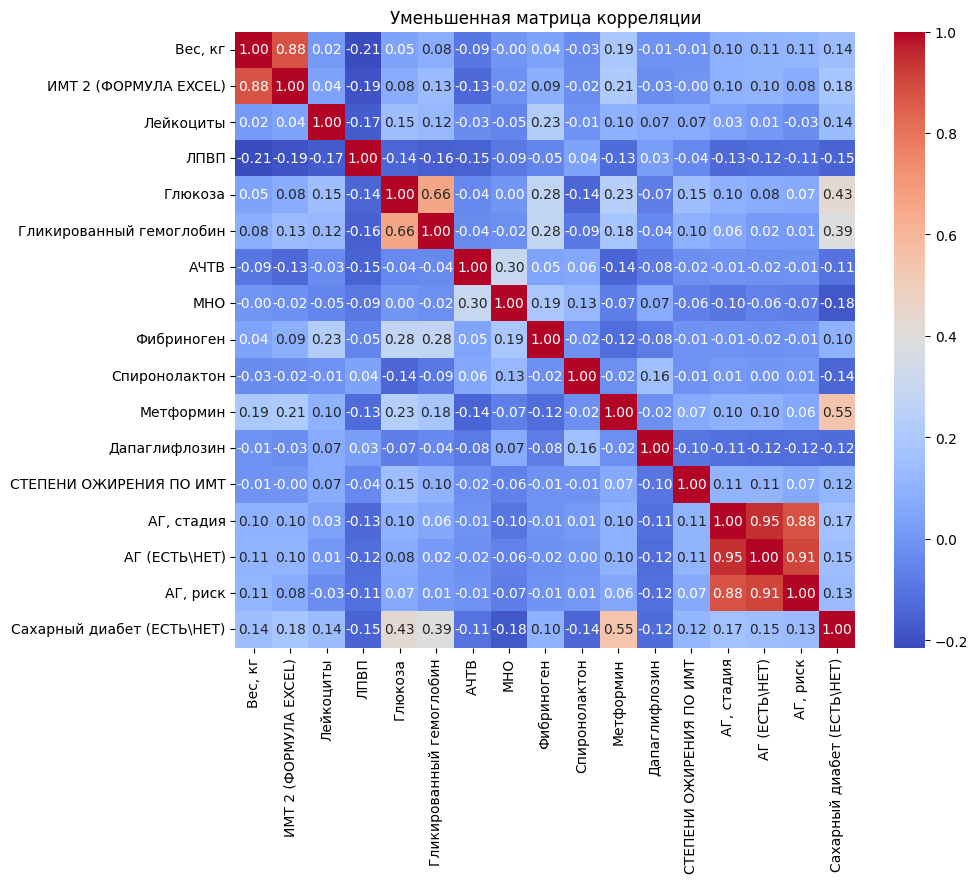

In [12]:
# Фильтрация по сильной корреляции с целевой переменной
correlation_matrix = data_cleaned.corr()

target_corr = correlation_matrix['Сахарный диабет (ЕСТЬ\\НЕТ)'].dropna()
strong_corr_features = target_corr[(target_corr.abs() > 0.1)].index

# Создание уменьшенной матрицы корреляции
reduced_corr_matrix = correlation_matrix.loc[strong_corr_features, strong_corr_features]

# Визуализация уменьшенной матрицы
plt.figure(figsize=(10, 8))
sns.heatmap(reduced_corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Уменьшенная матрица корреляции")
plt.show()

In [13]:
data_cleaned = data_cleaned[strong_corr_features]
data_cleaned = data_cleaned.drop(['Метформин','Гликированный гемоглобин','Дапаглифлозин'], axis = 1)
data_cleaned


,"Вес, кг",ИМТ 2 (ФОРМУЛА EXCEL),Лейкоциты,ЛПВП,Глюкоза,АЧТВ,МНО,Фибриноген,Спиронолактон,СТЕПЕНИ ОЖИРЕНИЯ ПО ИМТ,"АГ, стадия",АГ (ЕСТЬ\НЕТ),"АГ, риск",Сахарный диабет (ЕСТЬ\НЕТ)
0,86.0,34.449607,9.61,0.97,5.77,NaN,NaN,NaN,1.0,1.0,3.0,1.0,4.0,1.0
1,119.0,36.728395,10.48,1.19,5.91,38.2,2.34,3.71,0.0,2.0,3.0,1.0,4.0,1.0
2,110.0,36.332409,5.40,0.94,6.61,33.7,NaN,NaN,0.0,2.0,3.0,1.0,4.0,1.0
3,110.0,30.794211,8.50,NaN,4.98,26.3,1.09,3.68,1.0,1.0,3.0,1.0,4.0,1.0
4,115.0,36.295922,9.06,1.30,9.48,NaN,NaN,NaN,1.0,2.0,3.0,1.0,4.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
477,79.0,29.733900,5.80,1.31,6.30,NaN,NaN,NaN,1.0,4.0,0.0,0.0,0.0,1.0
478,87.0,30.824830,9.70,1.54,4.37,NaN,NaN,NaN,1.0,1.0,0.0,0.0,0.0,0.0
479,58.0,20.549887,6.62,3.67,5.45,NaN,NaN,NaN,1.0,0.0,0.0,0.0,0.0,0.0
480,61.0,21.107266,6.90,1.49,5.00,NaN,2.73,3.16,1.0,0.0,0.0,0.0,0.0,0.0


In [14]:
# data_cleaned.isna().sum()
data_cleaned[["АЧТВ","МНО","Фибриноген"]]
d_fibrinogen = data_cleaned['Фибриноген']
d_a4tv = data_cleaned['АЧТВ']
d_MNO = data_cleaned['МНО']

# d_fibrinogen.describe(), d_a4tv.describe(), d_MNO.describe()


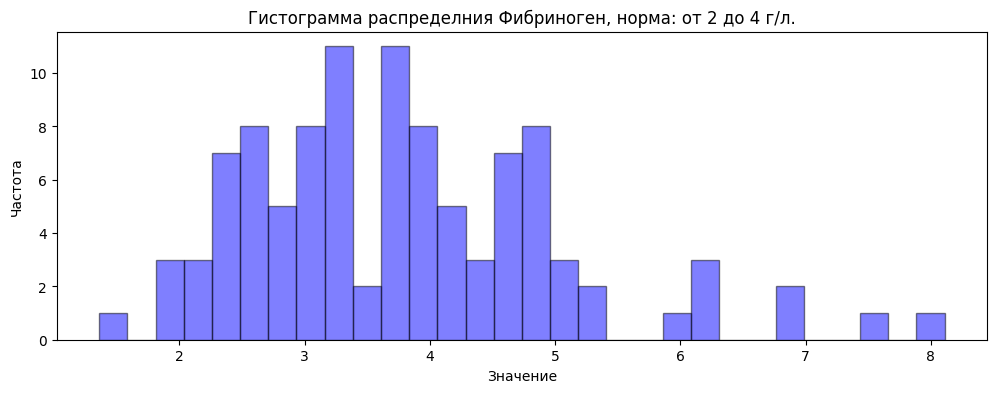

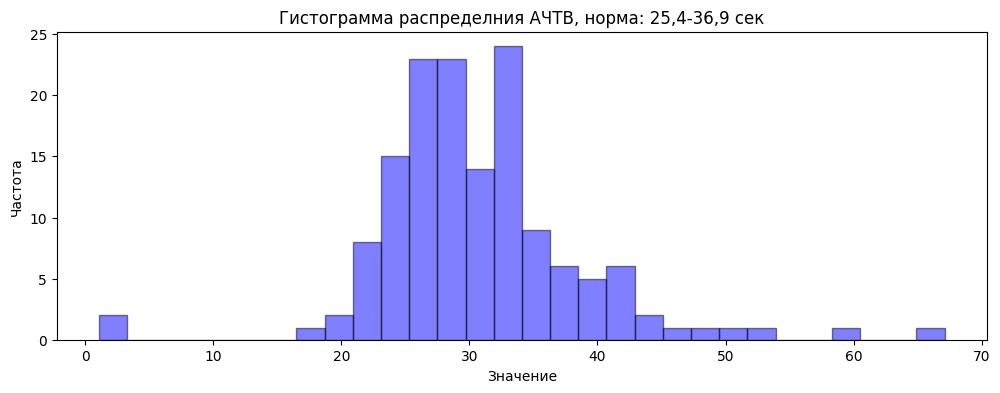

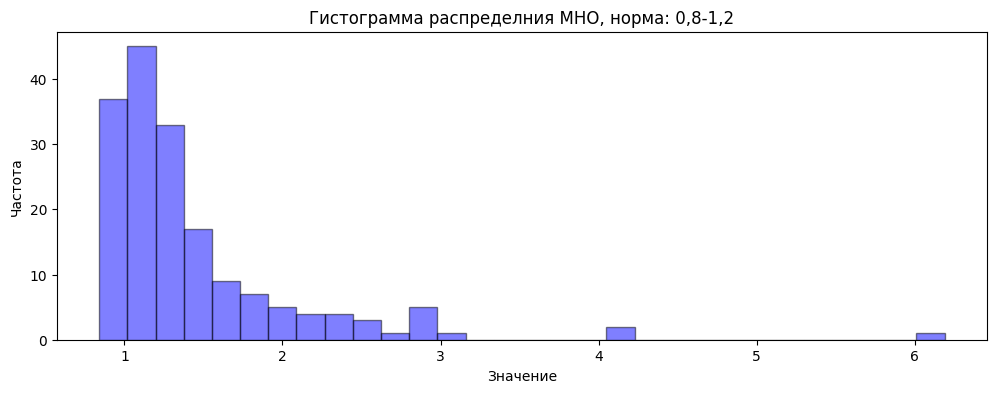

In [15]:
plt.figure(figsize=(12, 4))

data = d_fibrinogen

# Создаем гистограмму
plt.hist(data, bins=30, alpha=0.5, color='blue', edgecolor='black')

# Добавляем заголовок и метки осей
plt.title('Гистограмма распределния Фибриноген, норма: от 2 до 4 г/л.')
plt.xlabel('Значение')
plt.ylabel('Частота')

# Показываем график
plt.show()

plt.figure(figsize=(12, 4))

data = d_a4tv

# Создаем гистограмму
plt.hist(data, bins=30, alpha=0.5, color='blue', edgecolor='black')

# Добавляем заголовок и метки осей
plt.title('Гистограмма распределния АЧТВ, норма: 25,4-36,9 сек')
plt.xlabel('Значение')
plt.ylabel('Частота')

# Показываем график
plt.show()

plt.figure(figsize=(12, 4))

data = d_MNO

# Создаем гистограмму
plt.hist(data, bins=30, alpha=0.5, color='blue', edgecolor='black')

# Добавляем заголовок и метки осей
plt.title('Гистограмма распределния МНО, норма: 0,8-1,2')
plt.xlabel('Значение')
plt.ylabel('Частота')

# Показываем график
plt.show()


In [16]:

# Разделение на признаки и целевую переменную
X = data_cleaned.drop(columns=['Сахарный диабет (ЕСТЬ\НЕТ)'])
y = data_cleaned['Сахарный диабет (ЕСТЬ\НЕТ)']

# Заполняем медианой для числовых признаков
X = X.fillna(X.median(numeric_only=True))

# Разделение на обучающую и тестовую выборки (70/30, stratified)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=654321, stratify=y
)

# Масштабирование данных
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Кросс-валидация и обучение модели с регуляризацией
model = LogisticRegression(random_state=654321, C=0.5) 
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=654321)

cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=cv, scoring='f1_macro')
print(f"Среднее значение F1 Macro по кросс-валидации: {np.mean(cv_scores):.3f}")

# Обучение модели на полном обучающем наборе
model.fit(X_train_scaled, y_train)

# Оценка на тренировочной выборке
y_train_pred = model.predict(X_train_scaled)
train_f1 = f1_score(y_train, y_train_pred, average='macro')

# Оценка на тестовой выборке
y_test_pred = model.predict(X_test_scaled)
test_f1 = f1_score(y_test, y_test_pred, average='macro')

# Вывод метрик
print(f"F1 Macro (Train): {train_f1:.3f}")
print(f"F1 Macro (Test): {test_f1:.3f}")
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_test_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_test_pred))



Среднее значение F1 Macro по кросс-валидации: 0.712
F1 Macro (Train): 0.757
F1 Macro (Test): 0.741

Confusion Matrix:
[[47 20]
 [17 60]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.73      0.70      0.72        67
         1.0       0.75      0.78      0.76        77

    accuracy                           0.74       144
   macro avg       0.74      0.74      0.74       144
weighted avg       0.74      0.74      0.74       144

